In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
# import pymc as pm
# import pymc_bart as pmb

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, make_scorer, r2_score
from sklearn.model_selection import GridSearchCV, RepeatedKFold
from sklearn.feature_selection import RFECV, SelectFromModel
from sklearn.inspection import permutation_importance

In [2]:
def naive_roc_auc_score(y_true, y_pred):
  
  y_true = y_true.to_numpy()
  
  num_same_sign = 0
  num_pairs = 0
  
  for a in range(len(y_true)):
    for b in range(len(y_true)):
      if y_true[a] > y_true[b]:
        num_pairs += 1
        if y_pred[a] > y_pred[b]:
          num_same_sign += 1
        elif y_pred[a] == y_pred[b]:
          num_same_sign += .5
        
  return num_same_sign / num_pairs

score = make_scorer(naive_roc_auc_score, greater_is_better=True)

In [4]:
data = pd.read_csv('Dopant_Data.csv')

# get data
data.replace([np.inf, -np.inf], np.nan, inplace=True)
data = data.dropna()
y = data['LUMO']
X = data.loc[:, ['Molecular Weight', 'Heavy Atom Molecular Weight', 'Max Abs Partial Charge', 'Max Partial Charge', 
         'Min Abs Partial Charge', 'Min Partial Charge', 'Radical Electrons', 'Valence Electrons', 'NHOH Count', 'NO Count',
         'H Acceptors', 'H Donors', 'Ring Count', 'Aliphatic Rings', 'Aromatic Rings', 'Saturated Rings', 'Aromatic Carbocycles',
         'Aromatic Heterocycles', 'Heteroatoms', 'Rotatable Bonds', 'Saturated Carbocycles', 'Saturated Heterocycles', 'H Count',
         'C Count', 'N Count', 'F Count', 'Halogen Count', 'Double Bonds', 'Triple Bonds']]
list_numerical = X.columns


# split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=10)

In [5]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, RepeatedKFold

param_grid = {
    "max_depth": [3,5,10,15,20,None],
    "min_samples_split": [2,5,7,10],
    "min_samples_leaf": [1,2,5]
}

cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
rf = RandomForestRegressor(random_state=42)
grid_cv = GridSearchCV(rf, param_grid, scoring=score, n_jobs=-1, cv=cv).fit(X_train, y_train)

print("Param for GS", grid_cv.best_params_)
print("CV score for GS", grid_cv.best_score_)
print("Train AUC ROC Score for GS: ", naive_roc_auc_score(y_train, grid_cv.predict(X_train)))
print("Test AUC ROC Score for GS: ",naive_roc_auc_score(y_test, grid_cv.predict(X_test)))
print("Train R2: ", r2_score(y_train, grid_cv.predict(X_train)))
print("Test R2: ", r2_score(y_test, grid_cv.predict(X_test)))
# rmse = mse**.5
print("Train MSE: ", mean_squared_error(y_train, grid_cv.predict(X_train)))
print("Test MSE: ", mean_squared_error(y_test, grid_cv.predict(X_test)))

Param for GS {'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 5}
CV score for GS 0.7388888888888888
Train AUC ROC Score for GS:  0.9064102564102564
Test AUC ROC Score for GS:  0.7
Train R2:  0.892710352302294
Test R2:  0.46812187951171225
Train MSE:  0.594769624849188
Test MSE:  1.2286289249445133


Text(0.5, 1.0, 'LUMO')

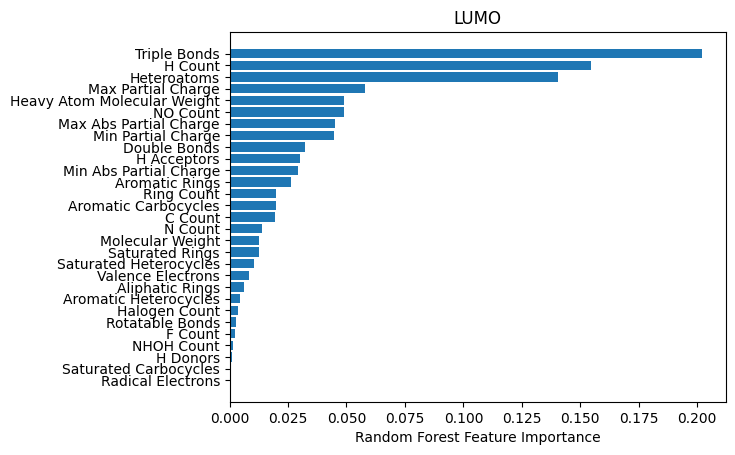

In [6]:
rfr = RandomForestRegressor(random_state=42, max_depth=20, min_samples_leaf=1, min_samples_split=2)
rfr.fit(X_train, y_train)

sorted_idx = rfr.feature_importances_.argsort()
plt.barh(list_numerical[sorted_idx], rfr.feature_importances_[sorted_idx])
plt.xlabel("Random Forest Feature Importance")
plt.title("LUMO")

In [7]:
r = permutation_importance(rfr, X_train, y_train,
                            n_repeats=30,
                            random_state=0)

for i in r.importances_mean.argsort()[::-1]:
     if r.importances_mean[i] - 2 * r.importances_std[i] > 0:
         print(f"{list_numerical[i]:<8}"
               f"{r.importances_mean[i]:.3f}"
               f" +/- {r.importances_std[i]:.3f}")

H Count 0.149 +/- 0.033
Triple Bonds0.137 +/- 0.030
Heteroatoms0.081 +/- 0.023
Double Bonds0.035 +/- 0.010
Min Partial Charge0.034 +/- 0.008
Max Partial Charge0.032 +/- 0.005
Max Abs Partial Charge0.029 +/- 0.007
Heavy Atom Molecular Weight0.027 +/- 0.009
Min Abs Partial Charge0.014 +/- 0.003
Aromatic Rings0.014 +/- 0.003
NO Count0.012 +/- 0.005
C Count 0.011 +/- 0.002
Ring Count0.009 +/- 0.003
Saturated Rings0.007 +/- 0.002
Molecular Weight0.006 +/- 0.002
Aromatic Carbocycles0.006 +/- 0.002
N Count 0.006 +/- 0.002
Saturated Heterocycles0.004 +/- 0.001
Valence Electrons0.004 +/- 0.001
Aliphatic Rings0.003 +/- 0.001
Halogen Count0.003 +/- 0.001
Aromatic Heterocycles0.003 +/- 0.001
Rotatable Bonds0.002 +/- 0.001
F Count 0.002 +/- 0.001
NHOH Count0.001 +/- 0.000
Saturated Carbocycles0.000 +/- 0.000


In [8]:
rfr.fit(X_train, y_train)

r = permutation_importance(rfr, X_test, y_test,
                            n_repeats=30,
                            random_state=0)

for i in r.importances_mean.argsort()[::-1]:
     if r.importances_mean[i] - 2 * r.importances_std[i] > 0:
         print(f"{list_numerical[i]:<8}"
               f"{r.importances_mean[i]:.3f}"
               f" +/- {r.importances_std[i]:.3f}")

Rotatable Bonds0.019 +/- 0.010


In [9]:
# Use the forest's predict method on the test data
predictions = rfr.predict(X_test)
# Calculate the absolute errors
errors = abs(predictions - y_test)
# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 2), 'eV.')
print("Train R2: ", r2_score(y_train, grid_cv.predict(X_train)))
print("Test R2: ", r2_score(y_test, grid_cv.predict(X_test)))
# rmse = mse**.5
print("Train MSE: ", mean_squared_error(y_train, grid_cv.predict(X_train)))
print("Test MSE: ", mean_squared_error(y_test, grid_cv.predict(X_test)))

Mean Absolute Error: 0.97 eV.
Train R2:  0.892710352302294
Test R2:  0.46812187951171225
Train MSE:  0.594769624849188
Test MSE:  1.2286289249445133


In [10]:
from sklearn.metrics import mean_squared_error

prediction = rfr.predict(X_test)
mse = mean_squared_error(y_test, prediction)
#calculate R-squared of regression model
r_squared = rfr.score(X_test, y_test)

#view R-squared value
print("R2: ", r_squared)
rmse = mse**.5
print("MSE: ", mse)
print("RMSE: ", rmse)

R2:  0.4743741051776895
MSE:  1.2141863957209984
RMSE:  1.1019012640527273


In [11]:
# Calculate mean absolute percentage error (MAPE)
mape = 100 * (errors / y_test)
# Calculate and display accuracy
accuracy = 100 - np.mean(mape)
print('Accuracy:', round(accuracy, 2), '%.')

Accuracy: 223.91 %.


In [12]:
naive_roc_auc_score(y_test, prediction)

0.8

In [13]:
data = pd.read_csv('Dopant_Data.csv')

# get data
data.replace([np.inf, -np.inf], np.nan, inplace=True)
data = data.dropna()
y = data['LUMO']
X = data.loc[:, ['Molecular Weight', 'Heavy Atom Molecular Weight', 'Max Abs Partial Charge', 'Max Partial Charge', 
         'Min Abs Partial Charge', 'Min Partial Charge', 'Radical Electrons', 'Valence Electrons', 'NO Count',
         'H Acceptors', 'H Donors', 'Ring Count', 'Aliphatic Rings', 'Aromatic Rings', 'Saturated Rings', 'Aromatic Carbocycles',
         'Aromatic Heterocycles', 'Heteroatoms', 'Rotatable Bonds', 'Saturated Heterocycles', 'H Count',
         'C Count', 'N Count', 'Halogen Count', 'Double Bonds', 'Triple Bonds']]
list_numerical = X.columns


# split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)

In [14]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, RepeatedKFold

param_grid = {
    "max_depth": [3,5,10,15,20,None],
    "min_samples_split": [2,5,7,10],
    "min_samples_leaf": [1,2,5]
}

cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
rf = RandomForestRegressor(random_state=42)
grid_cv = GridSearchCV(rf, param_grid, scoring=score, n_jobs=-1, cv=cv).fit(X_train, y_train)

print("Param for GS", grid_cv.best_params_)
print("CV score for GS", grid_cv.best_score_)
print("Train AUC ROC Score for GS: ", naive_roc_auc_score(y_train, grid_cv.predict(X_train)))
print("Test AUC ROC Score for GS: ",naive_roc_auc_score(y_test, grid_cv.predict(X_test)))
print("Train R2: ", r2_score(y_train, grid_cv.predict(X_train)))
print("Test R2: ", r2_score(y_test, grid_cv.predict(X_test)))
# rmse = mse**.5
print("Train MSE: ", mean_squared_error(y_train, grid_cv.predict(X_train)))
print("Test MSE: ", mean_squared_error(y_test, grid_cv.predict(X_test)))

Param for GS {'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 2}
CV score for GS 0.7833333333333334
Train AUC ROC Score for GS:  0.9206349206349206
Test AUC ROC Score for GS:  0.7777777777777778
Train R2:  0.931844923985921
Test R2:  0.5718358628559698
Train MSE:  0.36703672487402245
Test MSE:  2.437577732519899


Text(0.5, 1.0, 'LUMO')

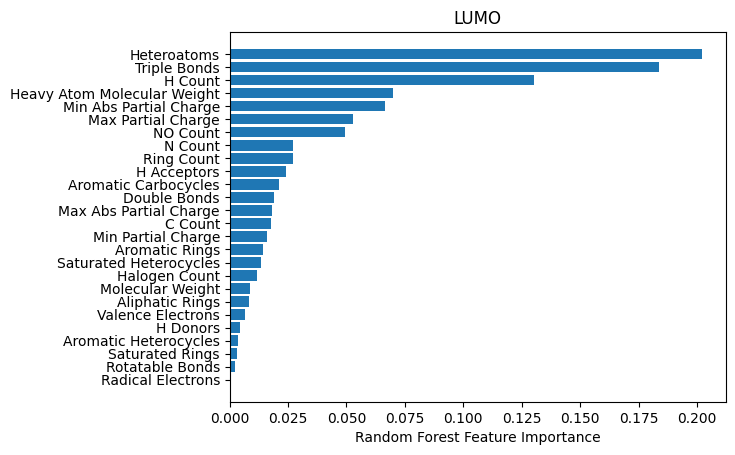

In [15]:
rfr = RandomForestRegressor(random_state=42, max_depth=20, min_samples_leaf=1, min_samples_split=2)
rfr.fit(X_train, y_train)

sorted_idx = rfr.feature_importances_.argsort()
plt.barh(list_numerical[sorted_idx], rfr.feature_importances_[sorted_idx])
plt.xlabel("Random Forest Feature Importance")
plt.title("LUMO")

In [16]:
r = permutation_importance(rfr, X_train, y_train,
                            n_repeats=30,
                            random_state=0)

for i in r.importances_mean.argsort()[::-1]:
     if r.importances_mean[i] - 2 * r.importances_std[i] > 0:
         print(f"{list_numerical[i]:<8}"
               f"{r.importances_mean[i]:.3f}"
               f" +/- {r.importances_std[i]:.3f}")

Heteroatoms0.163 +/- 0.042
Triple Bonds0.126 +/- 0.039
H Count 0.103 +/- 0.029
Heavy Atom Molecular Weight0.050 +/- 0.014
Min Abs Partial Charge0.034 +/- 0.011
Max Partial Charge0.026 +/- 0.008
Double Bonds0.016 +/- 0.005
N Count 0.014 +/- 0.005
C Count 0.014 +/- 0.003
Ring Count0.012 +/- 0.006
Aromatic Carbocycles0.010 +/- 0.004
Min Partial Charge0.010 +/- 0.002
Aromatic Rings0.010 +/- 0.002
Max Abs Partial Charge0.008 +/- 0.002
Saturated Heterocycles0.008 +/- 0.003
Aliphatic Rings0.006 +/- 0.002
H Acceptors0.005 +/- 0.002
Halogen Count0.005 +/- 0.002
Molecular Weight0.004 +/- 0.001
Valence Electrons0.003 +/- 0.001
Rotatable Bonds0.002 +/- 0.001
Saturated Rings0.002 +/- 0.001
Aromatic Heterocycles0.002 +/- 0.001
H Donors0.001 +/- 0.001


In [17]:
rfr.fit(X_train, y_train)

r = permutation_importance(rfr, X_test, y_test,
                            n_repeats=30,
                            random_state=0)

for i in r.importances_mean.argsort()[::-1]:
     if r.importances_mean[i] - 2 * r.importances_std[i] > 0:
         print(f"{list_numerical[i]:<8}"
               f"{r.importances_mean[i]:.3f}"
               f" +/- {r.importances_std[i]:.3f}")

Valence Electrons0.009 +/- 0.004


In [18]:
data = pd.read_csv('Dopant_Data.csv')

# get data
data.replace([np.inf, -np.inf], np.nan, inplace=True)
data = data.dropna()
y = data['LUMO']
X = data.loc[:, ['Molecular Weight', 'Heavy Atom Molecular Weight', 'Max Abs Partial Charge', 'Max Partial Charge', 
         'Min Abs Partial Charge', 'Min Partial Charge', 'Valence Electrons', 'NO Count',
         'H Acceptors', 'Ring Count', 'Aliphatic Rings', 'Aromatic Rings', 'Saturated Rings', 'Aromatic Carbocycles',
         'Heteroatoms', 'Rotatable Bonds', 'Saturated Heterocycles', 'H Count',
         'C Count', 'N Count', 'Halogen Count', 'Double Bonds', 'Triple Bonds']]
list_numerical = X.columns


# split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)

In [19]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, RepeatedKFold

param_grid = {
    "max_depth": [3,5,10,15,20,None],
    "min_samples_split": [2,5,7,10],
    "min_samples_leaf": [1,2,5]
}

cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
rf = RandomForestRegressor(random_state=42)
grid_cv = GridSearchCV(rf, param_grid, scoring=score, n_jobs=-1, cv=cv).fit(X_train, y_train)

print("Param for GS", grid_cv.best_params_)
print("CV score for GS", grid_cv.best_score_)
print("Train AUC ROC Score for GS: ", naive_roc_auc_score(y_train, grid_cv.predict(X_train)))
print("Test AUC ROC Score for GS: ",naive_roc_auc_score(y_test, grid_cv.predict(X_test)))
print("Train R2: ", r2_score(y_train, grid_cv.predict(X_train)))
print("Test R2: ", r2_score(y_test, grid_cv.predict(X_test)))
# rmse = mse**.5
print("Train MSE: ", mean_squared_error(y_train, grid_cv.predict(X_train)))
print("Test MSE: ", mean_squared_error(y_test, grid_cv.predict(X_test)))

Param for GS {'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 2}
CV score for GS 0.7833333333333333
Train AUC ROC Score for GS:  0.9222222222222223
Test AUC ROC Score for GS:  0.7777777777777778
Train R2:  0.9325505571753478
Test R2:  0.5698134357535909
Train MSE:  0.3632366660969459
Test MSE:  2.4490915956455845


Text(0.5, 1.0, 'LUMO')

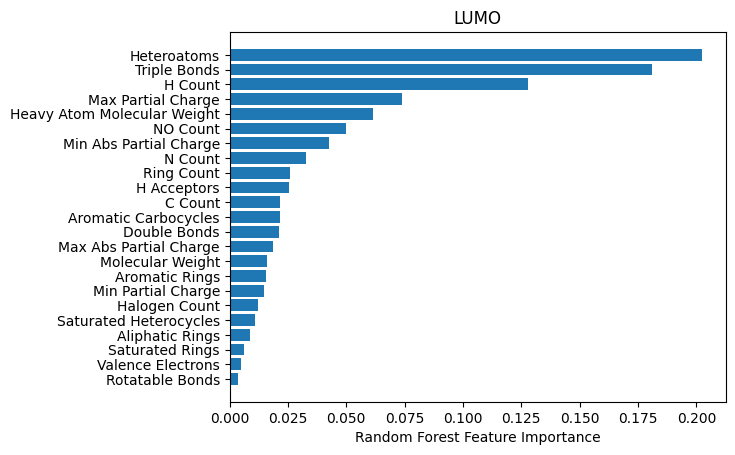

In [20]:
rfr = RandomForestRegressor(random_state=42, max_depth=20, min_samples_leaf=1, min_samples_split=2)
rfr.fit(X_train, y_train)

sorted_idx = rfr.feature_importances_.argsort()
plt.barh(list_numerical[sorted_idx], rfr.feature_importances_[sorted_idx])
plt.xlabel("Random Forest Feature Importance")
plt.title("LUMO")

In [21]:
r = permutation_importance(rfr, X_train, y_train,
                            n_repeats=30,
                            random_state=0)

for i in r.importances_mean.argsort()[::-1]:
     if r.importances_mean[i] - 2 * r.importances_std[i] > 0:
         print(f"{list_numerical[i]:<8}"
               f"{r.importances_mean[i]:.3f}"
               f" +/- {r.importances_std[i]:.3f}")

Heteroatoms0.160 +/- 0.040
Triple Bonds0.124 +/- 0.038
H Count 0.106 +/- 0.030
Heavy Atom Molecular Weight0.045 +/- 0.013
Max Partial Charge0.036 +/- 0.011
Min Abs Partial Charge0.021 +/- 0.007
Double Bonds0.019 +/- 0.007
N Count 0.018 +/- 0.007
C Count 0.016 +/- 0.003
Ring Count0.013 +/- 0.006
Aromatic Rings0.011 +/- 0.003
Min Partial Charge0.009 +/- 0.001
Max Abs Partial Charge0.009 +/- 0.002
Aromatic Carbocycles0.009 +/- 0.003
Aliphatic Rings0.008 +/- 0.002
Saturated Heterocycles0.007 +/- 0.002
H Acceptors0.006 +/- 0.002
Halogen Count0.005 +/- 0.002
Molecular Weight0.005 +/- 0.002
Valence Electrons0.003 +/- 0.001
Saturated Rings0.003 +/- 0.001


In [22]:
rfr.fit(X_train, y_train)

r = permutation_importance(rfr, X_test, y_test,
                            n_repeats=30,
                            random_state=0)

for i in r.importances_mean.argsort()[::-1]:
     if r.importances_mean[i] - 2 * r.importances_std[i] > 0:
         print(f"{list_numerical[i]:<8}"
               f"{r.importances_mean[i]:.3f}"
               f" +/- {r.importances_std[i]:.3f}")

Aliphatic Rings0.020 +/- 0.010
H Acceptors0.018 +/- 0.009
Valence Electrons0.008 +/- 0.002


In [23]:
data = pd.read_csv('Dopant_Data.csv')

# get data
data.replace([np.inf, -np.inf], np.nan, inplace=True)
data = data.dropna()
y = data['LUMO']
X = data.loc[:, ['Molecular Weight', 'Heavy Atom Molecular Weight', 'Max Abs Partial Charge', 'Max Partial Charge', 
         'Min Abs Partial Charge', 'Min Partial Charge', 'NO Count',
         'H Acceptors', 'Ring Count', 'Aliphatic Rings', 'Aromatic Rings', 'Saturated Rings', 'Aromatic Carbocycles',
         'Heteroatoms', 'Saturated Heterocycles', 'H Count',
         'C Count', 'N Count', 'Halogen Count', 'Double Bonds', 'Triple Bonds']]
list_numerical = X.columns


# split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)

In [24]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, RepeatedKFold

param_grid = {
    "max_depth": [3,5,10,15,20,None],
    "min_samples_split": [2,5,7,10],
    "min_samples_leaf": [1,2,5]
}

cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
rf = RandomForestRegressor(random_state=42)
grid_cv = GridSearchCV(rf, param_grid, scoring=score, n_jobs=-1, cv=cv).fit(X_train, y_train)

print("Param for GS", grid_cv.best_params_)
print("CV score for GS", grid_cv.best_score_)
print("Train AUC ROC Score for GS: ", naive_roc_auc_score(y_train, grid_cv.predict(X_train)))
print("Test AUC ROC Score for GS: ",naive_roc_auc_score(y_test, grid_cv.predict(X_test)))
print("Train R2: ", r2_score(y_train, grid_cv.predict(X_train)))
print("Test R2: ", r2_score(y_test, grid_cv.predict(X_test)))
# rmse = mse**.5
print("Train MSE: ", mean_squared_error(y_train, grid_cv.predict(X_train)))
print("Test MSE: ", mean_squared_error(y_test, grid_cv.predict(X_test)))

Param for GS {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2}
CV score for GS 0.7833333333333333
Train AUC ROC Score for GS:  0.9253968253968254
Test AUC ROC Score for GS:  0.7777777777777778
Train R2:  0.9323101406807635
Test R2:  0.5466345557625188
Train MSE:  0.3645313852571112
Test MSE:  2.581051086946889


Text(0.5, 1.0, 'LUMO')

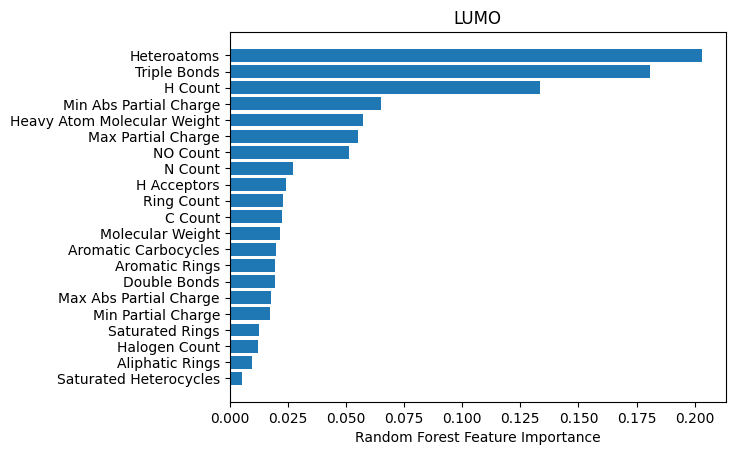

In [25]:
rfr = RandomForestRegressor(random_state=42, max_depth=20, min_samples_leaf=1, min_samples_split=2)
rfr.fit(X_train, y_train)

sorted_idx = rfr.feature_importances_.argsort()
plt.barh(list_numerical[sorted_idx], rfr.feature_importances_[sorted_idx])
plt.xlabel("Random Forest Feature Importance")
plt.title("LUMO")

In [26]:
r = permutation_importance(rfr, X_train, y_train,
                            n_repeats=30,
                            random_state=0)

for i in r.importances_mean.argsort()[::-1]:
     if r.importances_mean[i] - 2 * r.importances_std[i] > 0:
         print(f"{list_numerical[i]:<8}"
               f"{r.importances_mean[i]:.3f}"
               f" +/- {r.importances_std[i]:.3f}")

Heteroatoms0.157 +/- 0.040
Triple Bonds0.122 +/- 0.038
H Count 0.116 +/- 0.032
Heavy Atom Molecular Weight0.043 +/- 0.012
Min Abs Partial Charge0.034 +/- 0.010
Max Partial Charge0.025 +/- 0.008
C Count 0.017 +/- 0.004
Double Bonds0.017 +/- 0.005
N Count 0.017 +/- 0.006
Aromatic Rings0.012 +/- 0.004
Min Partial Charge0.009 +/- 0.002
Max Abs Partial Charge0.009 +/- 0.002
Aromatic Carbocycles0.009 +/- 0.003
Aliphatic Rings0.008 +/- 0.002
Saturated Rings0.007 +/- 0.003
Halogen Count0.006 +/- 0.002
Molecular Weight0.005 +/- 0.002
H Acceptors0.005 +/- 0.002
Saturated Heterocycles0.003 +/- 0.001


In [27]:
rfr.fit(X_train, y_train)

r = permutation_importance(rfr, X_test, y_test,
                            n_repeats=30,
                            random_state=0)

for i in r.importances_mean.argsort()[::-1]:
     if r.importances_mean[i] - 2 * r.importances_std[i] > 0:
         print(f"{list_numerical[i]:<8}"
               f"{r.importances_mean[i]:.3f}"
               f" +/- {r.importances_std[i]:.3f}")

Min Partial Charge0.030 +/- 0.014


In [28]:
data = pd.read_csv('Dopant_Data.csv')

# get data
data.replace([np.inf, -np.inf], np.nan, inplace=True)
data = data.dropna()
y = data['LUMO']
X = data.loc[:, ['Molecular Weight', 'Heavy Atom Molecular Weight', 'Max Abs Partial Charge', 'Max Partial Charge', 
         'Min Abs Partial Charge', 'Min Partial Charge', 'NO Count',
         'Ring Count', 'Aliphatic Rings', 'Aromatic Rings', 'Saturated Rings', 'Aromatic Carbocycles',
         'Heteroatoms', 'H Count',
         'C Count', 'N Count', 'Halogen Count', 'Double Bonds', 'Triple Bonds']]
list_numerical = X.columns


# split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)

In [29]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, RepeatedKFold

param_grid = {
    "max_depth": [3,5,10,15,20,None],
    "min_samples_split": [2,5,7,10],
    "min_samples_leaf": [1,2,5]
}

cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
rf = RandomForestRegressor(random_state=42)
grid_cv = GridSearchCV(rf, param_grid, scoring=score, n_jobs=-1, cv=cv).fit(X_train, y_train)

print("Param for GS", grid_cv.best_params_)
print("CV score for GS", grid_cv.best_score_)
print("Train AUC ROC Score for GS: ", naive_roc_auc_score(y_train, grid_cv.predict(X_train)))
print("Test AUC ROC Score for GS: ",naive_roc_auc_score(y_test, grid_cv.predict(X_test)))
print("Train R2: ", r2_score(y_train, grid_cv.predict(X_train)))
print("Test R2: ", r2_score(y_test, grid_cv.predict(X_test)))
# rmse = mse**.5
print("Train MSE: ", mean_squared_error(y_train, grid_cv.predict(X_train)))
print("Test MSE: ", mean_squared_error(y_test, grid_cv.predict(X_test)))

Param for GS {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2}
CV score for GS 0.7888888888888889
Train AUC ROC Score for GS:  0.9214285714285714
Test AUC ROC Score for GS:  0.7777777777777778
Train R2:  0.9365649352672969
Test R2:  0.5679634673497047
Train MSE:  0.3416179654300926
Test MSE:  2.459623635571342


Text(0.5, 1.0, 'LUMO')

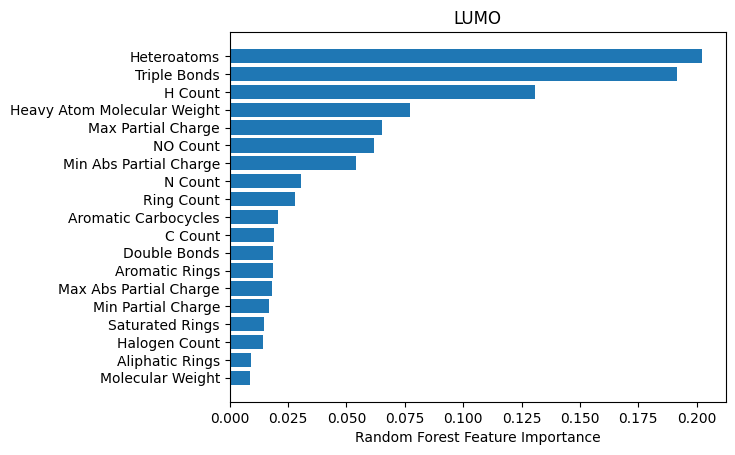

In [30]:
rfr = RandomForestRegressor(random_state=42, max_depth=20, min_samples_leaf=1, min_samples_split=2)
rfr.fit(X_train, y_train)

sorted_idx = rfr.feature_importances_.argsort()
plt.barh(list_numerical[sorted_idx], rfr.feature_importances_[sorted_idx])
plt.xlabel("Random Forest Feature Importance")
plt.title("LUMO")

In [31]:
r = permutation_importance(rfr, X_train, y_train,
                            n_repeats=30,
                            random_state=0)

for i in r.importances_mean.argsort()[::-1]:
     if r.importances_mean[i] - 2 * r.importances_std[i] > 0:
         print(f"{list_numerical[i]:<8}"
               f"{r.importances_mean[i]:.3f}"
               f" +/- {r.importances_std[i]:.3f}")

Heteroatoms0.156 +/- 0.039
Triple Bonds0.125 +/- 0.039
H Count 0.108 +/- 0.030
Heavy Atom Molecular Weight0.056 +/- 0.015
Max Partial Charge0.035 +/- 0.010
Min Abs Partial Charge0.029 +/- 0.008
NO Count0.022 +/- 0.010
Double Bonds0.018 +/- 0.006
N Count 0.018 +/- 0.006
C Count 0.013 +/- 0.003
Aromatic Rings0.012 +/- 0.004
Ring Count0.012 +/- 0.005
Saturated Rings0.010 +/- 0.003
Max Abs Partial Charge0.010 +/- 0.002
Min Partial Charge0.009 +/- 0.001
Aromatic Carbocycles0.009 +/- 0.003
Aliphatic Rings0.007 +/- 0.002
Halogen Count0.006 +/- 0.002
Molecular Weight0.003 +/- 0.001


In [32]:
rfr.fit(X_train, y_train)

r = permutation_importance(rfr, X_test, y_test,
                            n_repeats=30,
                            random_state=0)

for i in r.importances_mean.argsort()[::-1]:
     if r.importances_mean[i] - 2 * r.importances_std[i] > 0:
         print(f"{list_numerical[i]:<8}"
               f"{r.importances_mean[i]:.3f}"
               f" +/- {r.importances_std[i]:.3f}")

Aliphatic Rings0.021 +/- 0.010


In [33]:
data = pd.read_csv('Dopant_Data.csv')

# get data
data.replace([np.inf, -np.inf], np.nan, inplace=True)
data = data.dropna()
y = data['LUMO']
X = data.loc[:, ['Heavy Atom Molecular Weight', 'Max Abs Partial Charge', 'Max Partial Charge', 
         'Min Abs Partial Charge', 'Min Partial Charge', 'NO Count',
         'Ring Count', 'Aromatic Rings', 'Saturated Rings', 'Aromatic Carbocycles',
         'Heteroatoms', 'H Count',
         'C Count', 'N Count', 'Halogen Count', 'Double Bonds', 'Triple Bonds']]
list_numerical = X.columns


# split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)

In [34]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, RepeatedKFold

param_grid = {
    "max_depth": [3,5,10,15,20,None],
    "min_samples_split": [2,5,7,10],
    "min_samples_leaf": [1,2,5]
}

cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
rf = RandomForestRegressor(random_state=42)
grid_cv = GridSearchCV(rf, param_grid, scoring=score, n_jobs=-1, cv=cv).fit(X_train, y_train)

print("Param for GS", grid_cv.best_params_)
print("CV score for GS", grid_cv.best_score_)
print("Train AUC ROC Score for GS: ", naive_roc_auc_score(y_train, grid_cv.predict(X_train)))
print("Test AUC ROC Score for GS: ",naive_roc_auc_score(y_test, grid_cv.predict(X_test)))
print("Train R2: ", r2_score(y_train, grid_cv.predict(X_train)))
print("Test R2: ", r2_score(y_test, grid_cv.predict(X_test)))
# rmse = mse**.5
print("Train MSE: ", mean_squared_error(y_train, grid_cv.predict(X_train)))
print("Test MSE: ", mean_squared_error(y_test, grid_cv.predict(X_test)))

Param for GS {'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 2}
CV score for GS 0.7833333333333333
Train AUC ROC Score for GS:  0.8992063492063492
Test AUC ROC Score for GS:  0.7777777777777778
Train R2:  0.9052196722731025
Test R2:  0.554466770376263
Train MSE:  0.5104221593734376
Test MSE:  2.5364615702579716


Text(0.5, 1.0, 'LUMO')

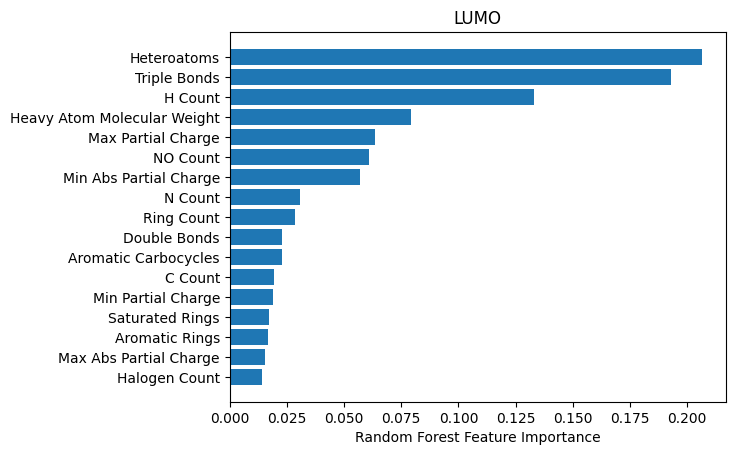

In [35]:
rfr = RandomForestRegressor(random_state=42, max_depth=20, min_samples_leaf=1, min_samples_split=2)
rfr.fit(X_train, y_train)

sorted_idx = rfr.feature_importances_.argsort()
plt.barh(list_numerical[sorted_idx], rfr.feature_importances_[sorted_idx])
plt.xlabel("Random Forest Feature Importance")
plt.title("LUMO")

In [36]:
r = permutation_importance(rfr, X_train, y_train,
                            n_repeats=30,
                            random_state=0)

for i in r.importances_mean.argsort()[::-1]:
     if r.importances_mean[i] - 2 * r.importances_std[i] > 0:
         print(f"{list_numerical[i]:<8}"
               f"{r.importances_mean[i]:.3f}"
               f" +/- {r.importances_std[i]:.3f}")

Heteroatoms0.173 +/- 0.043
Triple Bonds0.121 +/- 0.039
H Count 0.112 +/- 0.030
Heavy Atom Molecular Weight0.058 +/- 0.016
Max Partial Charge0.029 +/- 0.009
Min Abs Partial Charge0.029 +/- 0.009
Double Bonds0.025 +/- 0.008
NO Count0.022 +/- 0.010
N Count 0.018 +/- 0.006
C Count 0.015 +/- 0.004
Ring Count0.013 +/- 0.006
Aromatic Rings0.013 +/- 0.004
Min Partial Charge0.011 +/- 0.002
Aromatic Carbocycles0.011 +/- 0.003
Saturated Rings0.010 +/- 0.004
Max Abs Partial Charge0.009 +/- 0.002
Halogen Count0.007 +/- 0.002


In [37]:
rfr.fit(X_train, y_train)

r = permutation_importance(rfr, X_test, y_test,
                            n_repeats=30,
                            random_state=0)

for i in r.importances_mean.argsort()[::-1]:
     if r.importances_mean[i] - 2 * r.importances_std[i] > 0:
         print(f"{list_numerical[i]:<8}"
               f"{r.importances_mean[i]:.3f}"
               f" +/- {r.importances_std[i]:.3f}")

In [38]:
data = pd.read_csv('Dopant_Data.csv')

# get data
data.replace([np.inf, -np.inf], np.nan, inplace=True)
data = data.dropna()
y = data['LUMO']
X = data.loc[:, ['Heavy Atom Molecular Weight', 'Max Abs Partial Charge', 
         'Min Abs Partial Charge', 'Min Partial Charge', 'NO Count',
         'Ring Count', 'Saturated Rings', 'Aromatic Carbocycles',
         'Heteroatoms', 'H Count',
         'C Count', 'N Count', 'Double Bonds', 'Triple Bonds']]
list_numerical = X.columns


# split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)

In [39]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, RepeatedKFold

param_grid = {
    "max_depth": [3,5,10,15,20,None],
    "min_samples_split": [2,5,7,10],
    "min_samples_leaf": [1,2,5]
}

cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
rf = RandomForestRegressor(random_state=42)
grid_cv = GridSearchCV(rf, param_grid, scoring=score, n_jobs=-1, cv=cv).fit(X_train, y_train)

print("Param for GS", grid_cv.best_params_)
print("CV score for GS", grid_cv.best_score_)
print("Train AUC ROC Score for GS: ", naive_roc_auc_score(y_train, grid_cv.predict(X_train)))
print("Test AUC ROC Score for GS: ",naive_roc_auc_score(y_test, grid_cv.predict(X_test)))
print("Train R2: ", r2_score(y_train, grid_cv.predict(X_train)))
print("Test R2: ", r2_score(y_test, grid_cv.predict(X_test)))
# rmse = mse**.5
print("Train MSE: ", mean_squared_error(y_train, grid_cv.predict(X_train)))
print("Test MSE: ", mean_squared_error(y_test, grid_cv.predict(X_test)))

Param for GS {'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 2}
CV score for GS 0.7944444444444445
Train AUC ROC Score for GS:  0.9246031746031746
Test AUC ROC Score for GS:  0.7777777777777778
Train R2:  0.934278578591974
Test R2:  0.5444058118638203
Train MSE:  0.35393072208861365
Test MSE:  2.593739530531153


Text(0.5, 1.0, 'LUMO')

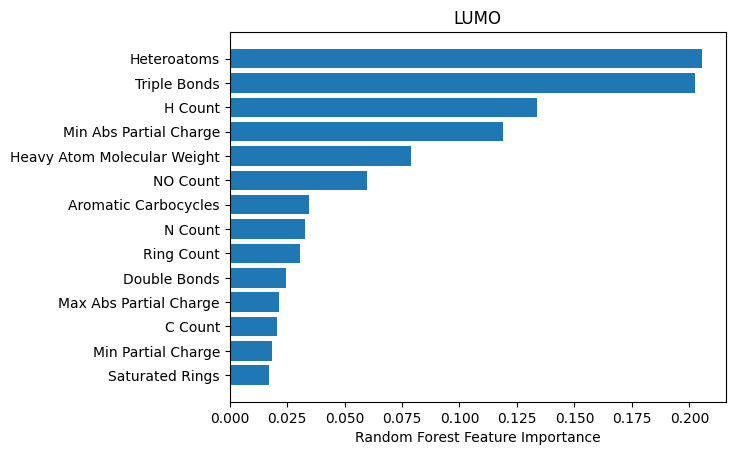

In [40]:
rfr = RandomForestRegressor(random_state=42, max_depth=20, min_samples_leaf=1, min_samples_split=2)
rfr.fit(X_train, y_train)

sorted_idx = rfr.feature_importances_.argsort()
plt.barh(list_numerical[sorted_idx], rfr.feature_importances_[sorted_idx])
plt.xlabel("Random Forest Feature Importance")
plt.title("LUMO")

In [41]:
r = permutation_importance(rfr, X_train, y_train,
                            n_repeats=30,
                            random_state=0)

for i in r.importances_mean.argsort()[::-1]:
     if r.importances_mean[i] - 2 * r.importances_std[i] > 0:
         print(f"{list_numerical[i]:<8}"
               f"{r.importances_mean[i]:.3f}"
               f" +/- {r.importances_std[i]:.3f}")

Heteroatoms0.172 +/- 0.043
Triple Bonds0.148 +/- 0.045
H Count 0.114 +/- 0.029
Min Abs Partial Charge0.074 +/- 0.021
Heavy Atom Molecular Weight0.057 +/- 0.015
Double Bonds0.025 +/- 0.008
Aromatic Carbocycles0.021 +/- 0.007
NO Count0.020 +/- 0.009
N Count 0.019 +/- 0.006
C Count 0.017 +/- 0.004
Ring Count0.016 +/- 0.007
Saturated Rings0.011 +/- 0.004
Min Partial Charge0.010 +/- 0.002
Max Abs Partial Charge0.009 +/- 0.002


In [42]:
rfr.fit(X_train, y_train)

r = permutation_importance(rfr, X_test, y_test,
                            n_repeats=30,
                            random_state=0)

for i in r.importances_mean.argsort()[::-1]:
     if r.importances_mean[i] - 2 * r.importances_std[i] > 0:
         print(f"{list_numerical[i]:<8}"
               f"{r.importances_mean[i]:.3f}"
               f" +/- {r.importances_std[i]:.3f}")

In [43]:
data = pd.read_csv('Dopant_Data.csv')

# get data
data.replace([np.inf, -np.inf], np.nan, inplace=True)
data = data.dropna()
y = data['LUMO']
X = data.loc[:, ['Heavy Atom Molecular Weight', 'Max Abs Partial Charge', 
         'Min Abs Partial Charge', 'Min Partial Charge', 'NO Count',
         'Aromatic Carbocycles',
         'Heteroatoms', 'H Count',
         'C Count', 'N Count', 'Double Bonds', 'Triple Bonds']]
list_numerical = X.columns


# split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)

In [44]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, RepeatedKFold

param_grid = {
    "max_depth": [3,5,10,15,20,None],
    "min_samples_split": [2,5,7,10],
    "min_samples_leaf": [1,2,5]
}

cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
rf = RandomForestRegressor(random_state=42)
grid_cv = GridSearchCV(rf, param_grid, scoring=score, n_jobs=-1, cv=cv).fit(X_train, y_train)

print("Param for GS", grid_cv.best_params_)
print("CV score for GS", grid_cv.best_score_)
print("Train AUC ROC Score for GS: ", naive_roc_auc_score(y_train, grid_cv.predict(X_train)))
print("Test AUC ROC Score for GS: ",naive_roc_auc_score(y_test, grid_cv.predict(X_test)))
print("Train R2: ", r2_score(y_train, grid_cv.predict(X_train)))
print("Test R2: ", r2_score(y_test, grid_cv.predict(X_test)))
# rmse = mse**.5
print("Train MSE: ", mean_squared_error(y_train, grid_cv.predict(X_train)))
print("Test MSE: ", mean_squared_error(y_test, grid_cv.predict(X_test)))

Param for GS {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2}
CV score for GS 0.788888888888889
Train AUC ROC Score for GS:  0.9261904761904762
Test AUC ROC Score for GS:  0.7777777777777778
Train R2:  0.9395384449097737
Test R2:  0.5542056995868191
Train MSE:  0.3256046718592578
Test MSE:  2.5379478702250933


Text(0.5, 1.0, 'LUMO')

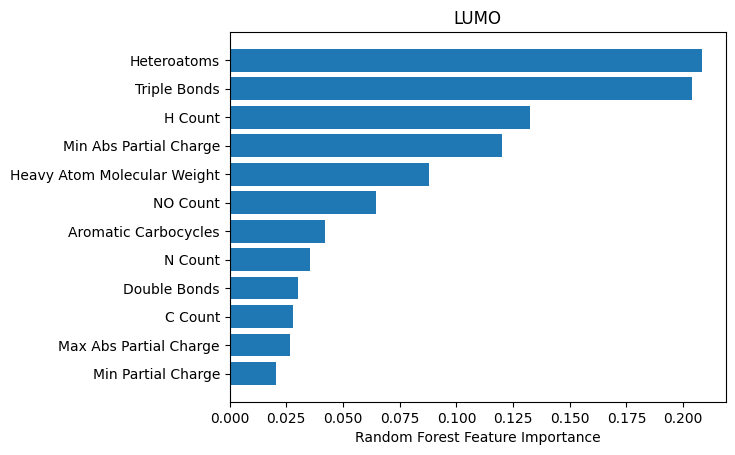

In [45]:
rfr = RandomForestRegressor(random_state=42, max_depth=20, min_samples_leaf=1, min_samples_split=2)
rfr.fit(X_train, y_train)

sorted_idx = rfr.feature_importances_.argsort()
plt.barh(list_numerical[sorted_idx], rfr.feature_importances_[sorted_idx])
plt.xlabel("Random Forest Feature Importance")
plt.title("LUMO")

In [46]:
r = permutation_importance(rfr, X_train, y_train,
                            n_repeats=30,
                            random_state=0)

for i in r.importances_mean.argsort()[::-1]:
     if r.importances_mean[i] - 2 * r.importances_std[i] > 0:
         print(f"{list_numerical[i]:<8}"
               f"{r.importances_mean[i]:.3f}"
               f" +/- {r.importances_std[i]:.3f}")

Heteroatoms0.190 +/- 0.049
Triple Bonds0.143 +/- 0.042
H Count 0.109 +/- 0.030
Min Abs Partial Charge0.077 +/- 0.022
Heavy Atom Molecular Weight0.065 +/- 0.018
Double Bonds0.027 +/- 0.008
Aromatic Carbocycles0.027 +/- 0.009
C Count 0.022 +/- 0.005
NO Count0.022 +/- 0.009
N Count 0.019 +/- 0.006
Max Abs Partial Charge0.013 +/- 0.002
Min Partial Charge0.009 +/- 0.001


In [47]:
rfr.fit(X_train, y_train)

r = permutation_importance(rfr, X_test, y_test,
                            n_repeats=30,
                            random_state=0)

for i in r.importances_mean.argsort()[::-1]:
     if r.importances_mean[i] - 2 * r.importances_std[i] > 0:
         print(f"{list_numerical[i]:<8}"
               f"{r.importances_mean[i]:.3f}"
               f" +/- {r.importances_std[i]:.3f}")

In [48]:
data = pd.read_csv('Dopant_Data.csv')

# get data
data.replace([np.inf, -np.inf], np.nan, inplace=True)
data = data.dropna()
y = data['LUMO']
X = data.loc[:, ['Heavy Atom Molecular Weight', 'Max Abs Partial Charge', 
         'Min Abs Partial Charge', 'NO Count',
         'Aromatic Carbocycles',
         'Heteroatoms', 'H Count','N Count',  'Triple Bonds']]
list_numerical = X.columns


# split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)

In [49]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, RepeatedKFold

param_grid = {
    "max_depth": [3,5,10,15,20,None],
    "min_samples_split": [2,5,7,10],
    "min_samples_leaf": [1,2,5]
}

cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
rf = RandomForestRegressor(random_state=42)
grid_cv = GridSearchCV(rf, param_grid, scoring=score, n_jobs=-1, cv=cv).fit(X_train, y_train)

print("Param for GS", grid_cv.best_params_)
print("CV score for GS", grid_cv.best_score_)
print("Train AUC ROC Score for GS: ", naive_roc_auc_score(y_train, grid_cv.predict(X_train)))
print("Test AUC ROC Score for GS: ",naive_roc_auc_score(y_test, grid_cv.predict(X_test)))
print("Train R2: ", r2_score(y_train, grid_cv.predict(X_train)))
print("Test R2: ", r2_score(y_test, grid_cv.predict(X_test)))
# rmse = mse**.5
print("Train MSE: ", mean_squared_error(y_train, grid_cv.predict(X_train)))
print("Test MSE: ", mean_squared_error(y_test, grid_cv.predict(X_test)))

Param for GS {'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 2}
CV score for GS 0.8000000000000002
Train AUC ROC Score for GS:  0.930952380952381
Test AUC ROC Score for GS:  0.7777777777777778
Train R2:  0.9332903990446333
Test R2:  0.4952542372471249
Train MSE:  0.35925238271692095
Test MSE:  2.873563956283195


Text(0.5, 1.0, 'LUMO')

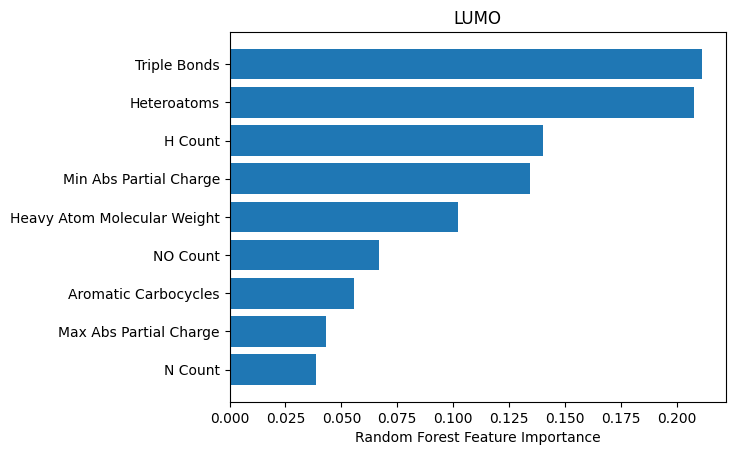

In [50]:
rfr = RandomForestRegressor(random_state=42, max_depth=20, min_samples_leaf=1, min_samples_split=2)
rfr.fit(X_train, y_train)

sorted_idx = rfr.feature_importances_.argsort()
plt.barh(list_numerical[sorted_idx], rfr.feature_importances_[sorted_idx])
plt.xlabel("Random Forest Feature Importance")
plt.title("LUMO")

In [51]:
r = permutation_importance(rfr, X_train, y_train,
                            n_repeats=30,
                            random_state=0)

for i in r.importances_mean.argsort()[::-1]:
     if r.importances_mean[i] - 2 * r.importances_std[i] > 0:
         print(f"{list_numerical[i]:<8}"
               f"{r.importances_mean[i]:.3f}"
               f" +/- {r.importances_std[i]:.3f}")

Heteroatoms0.187 +/- 0.047
Triple Bonds0.162 +/- 0.048
H Count 0.127 +/- 0.036
Min Abs Partial Charge0.106 +/- 0.029
Heavy Atom Molecular Weight0.087 +/- 0.023
Aromatic Carbocycles0.037 +/- 0.012
Max Abs Partial Charge0.025 +/- 0.004
N Count 0.023 +/- 0.006
NO Count0.022 +/- 0.009


In [52]:
rfr.fit(X_train, y_train)

r = permutation_importance(rfr, X_test, y_test,
                            n_repeats=30,
                            random_state=0)

for i in r.importances_mean.argsort()[::-1]:
     if r.importances_mean[i] - 2 * r.importances_std[i] > 0:
         print(f"{list_numerical[i]:<8}"
               f"{r.importances_mean[i]:.3f}"
               f" +/- {r.importances_std[i]:.3f}")

In [53]:
data = pd.read_csv('Dopant_Data.csv')

# get data
data.replace([np.inf, -np.inf], np.nan, inplace=True)
data = data.dropna()
y = data['LUMO']
X = data.loc[:, ['Molecular Weight', 'Max Partial Charge', 
         'Min Abs Partial Charge', 'NO Count',
         'Heteroatoms', 'H Count',  'Triple Bonds']]
list_numerical = X.columns


# split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)

In [54]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, RepeatedKFold

param_grid = {
    "max_depth": [3,5,10,15,20,None],
    "min_samples_split": [2,5,7,10],
    "min_samples_leaf": [1,2,5]
}

cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
rf = RandomForestRegressor(random_state=42)
grid_cv = GridSearchCV(rf, param_grid, scoring=score, n_jobs=-1, cv=cv).fit(X_train, y_train)

print("Param for GS", grid_cv.best_params_)
print("CV score for GS", grid_cv.best_score_)
print("Train AUC ROC Score for GS: ", naive_roc_auc_score(y_train, grid_cv.predict(X_train)))
print("Test AUC ROC Score for GS: ",naive_roc_auc_score(y_test, grid_cv.predict(X_test)))
print('Train Mean Absolute Error:', abs(grid_cv.predict(X_train) - y_train), 'degrees.')
print("Train R2: ", r2_score(y_train, grid_cv.predict(X_train)))
print("Test R2: ", r2_score(y_test, grid_cv.predict(X_test)))
# rmse = mse**.5
print("Train MSE: ", mean_squared_error(y_train, grid_cv.predict(X_train)))
print("Test MSE: ", mean_squared_error(y_test, grid_cv.predict(X_test)))

Param for GS {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2}
CV score for GS 0.7888888888888891
Train AUC ROC Score for GS:  0.942063492063492
Test AUC ROC Score for GS:  0.7777777777777778
Train Mean Absolute Error: 7     0.444572
6     0.838543
2     0.531271
37    0.589835
39    0.499314
35    0.068527
44    0.060089
27    0.383348
12    0.168643
31    1.505349
21    0.037345
5     0.745493
13    0.084673
19    0.317212
17    0.551214
14    0.158547
4     0.707489
45    0.556801
1     0.256973
26    0.064932
32    0.011250
24    0.138948
22    0.142981
11    0.198596
16    0.803121
43    0.022990
46    0.323211
8     0.100693
38    0.005389
29    0.629898
25    0.199281
28    0.024257
0     0.570930
15    1.464312
36    0.422065
9     0.348109
Name: LUMO, dtype: float64 degrees.
Train R2:  0.94764142616884
Test R2:  0.5570752724383461
Train MSE:  0.2819675449278918
Test MSE:  2.5216111285928227


Text(0.5, 1.0, 'LUMO')

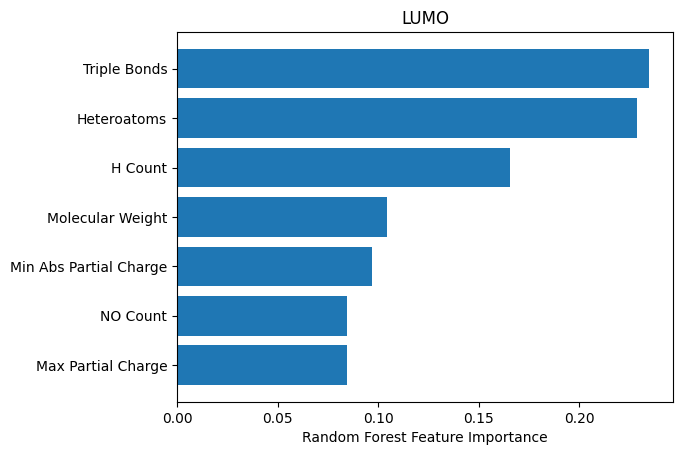

In [55]:
rfr = RandomForestRegressor(random_state=42, max_depth=20, min_samples_leaf=1, min_samples_split=2)
rfr.fit(X_train, y_train)

sorted_idx = rfr.feature_importances_.argsort()
plt.barh(list_numerical[sorted_idx], rfr.feature_importances_[sorted_idx])
plt.xlabel("Random Forest Feature Importance")
plt.title("LUMO")

In [56]:
r = permutation_importance(rfr, X_train, y_train,
                            n_repeats=30,
                            random_state=0)

for i in r.importances_mean.argsort()[::-1]:
     if r.importances_mean[i] - 2 * r.importances_std[i] > 0:
         print(f"{list_numerical[i]:<8}"
               f"{r.importances_mean[i]:.3f}"
               f" +/- {r.importances_std[i]:.3f}")

Heteroatoms0.221 +/- 0.056
Triple Bonds0.221 +/- 0.058
H Count 0.155 +/- 0.043
Molecular Weight0.102 +/- 0.026
Min Abs Partial Charge0.058 +/- 0.015
Max Partial Charge0.042 +/- 0.009
NO Count0.033 +/- 0.009


In [57]:
rfr.fit(X_train, y_train)

r = permutation_importance(rfr, X_test, y_test,
                            n_repeats=30,
                            random_state=0)

for i in r.importances_mean.argsort()[::-1]:
     if r.importances_mean[i] - 2 * r.importances_std[i] > 0:
         print(f"{list_numerical[i]:<8}"
               f"{r.importances_mean[i]:.3f}"
               f" +/- {r.importances_std[i]:.3f}")

In [58]:
data = pd.read_csv('Dopant_Data.csv')

# get data
data.replace([np.inf, -np.inf], np.nan, inplace=True)
data = data.dropna()
y = data['HOMO']
X = data.loc[:, ['Molecular Weight', 'Heavy Atom Molecular Weight', 'Max Abs Partial Charge', 'Max Partial Charge', 
         'Min Abs Partial Charge', 'Min Partial Charge', 'Radical Electrons', 'Valence Electrons', 'NHOH Count', 'NO Count',
         'H Acceptors', 'H Donors', 'Ring Count', 'Aliphatic Rings', 'Aromatic Rings', 'Saturated Rings', 'Aromatic Carbocycles',
         'Aromatic Heterocycles', 'Heteroatoms', 'Rotatable Bonds', 'Saturated Carbocycles', 'Saturated Heterocycles', 'H Count',
         'C Count', 'N Count', 'F Count', 'Halogen Count', 'Double Bonds', 'Triple Bonds']]
list_numerical = X.columns


# split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=10)

param_grid = {
    "max_depth": [3,5,10,15,20,None],
    "min_samples_split": [2,5,7,10],
    "min_samples_leaf": [1,2,5]
}

cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
rf = RandomForestRegressor(random_state=42)
grid_cv = GridSearchCV(rf, param_grid, scoring=score, n_jobs=-1, cv=cv).fit(X_train, y_train)

print("Param for GS", grid_cv.best_params_)
print("CV score for GS", grid_cv.best_score_)
print("Train AUC ROC Score for GS: ", naive_roc_auc_score(y_train, grid_cv.predict(X_train)))
print("Test AUC ROC Score for GS: ",naive_roc_auc_score(y_test, grid_cv.predict(X_test)))
print("Train R2: ", r2_score(y_train, grid_cv.predict(X_train)))
print("Test R2: ", r2_score(y_test, grid_cv.predict(X_test)))
# rmse = mse**.5
print("Train MSE: ", mean_squared_error(y_train, grid_cv.predict(X_train)))
print("Test MSE: ", mean_squared_error(y_test, grid_cv.predict(X_test)))

Param for GS {'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 2}
CV score for GS 0.7666666666666665
Train AUC ROC Score for GS:  0.9307692307692308
Test AUC ROC Score for GS:  0.7
Train R2:  0.9352881848591085
Test R2:  0.2876866006210802
Train MSE:  0.23310406241780152
Test MSE:  1.324526617933212


H Count 0.719 +/- 0.164
Max Partial Charge0.077 +/- 0.019
Min Abs Partial Charge0.077 +/- 0.020
Molecular Weight0.036 +/- 0.013
Heavy Atom Molecular Weight0.032 +/- 0.011
Double Bonds0.021 +/- 0.005
Aliphatic Rings0.020 +/- 0.004
Halogen Count0.019 +/- 0.006
C Count 0.009 +/- 0.004
Ring Count0.009 +/- 0.004
H Acceptors0.007 +/- 0.002
Max Abs Partial Charge0.007 +/- 0.003
NO Count0.006 +/- 0.003
Heteroatoms0.006 +/- 0.003
Valence Electrons0.005 +/- 0.002
Aromatic Rings0.005 +/- 0.001
Aromatic Carbocycles0.005 +/- 0.002
Aromatic Heterocycles0.004 +/- 0.002
N Count 0.003 +/- 0.001
Triple Bonds0.002 +/- 0.001
Saturated Heterocycles0.001 +/- 0.000
Saturated Rings0.001 +/- 0.000


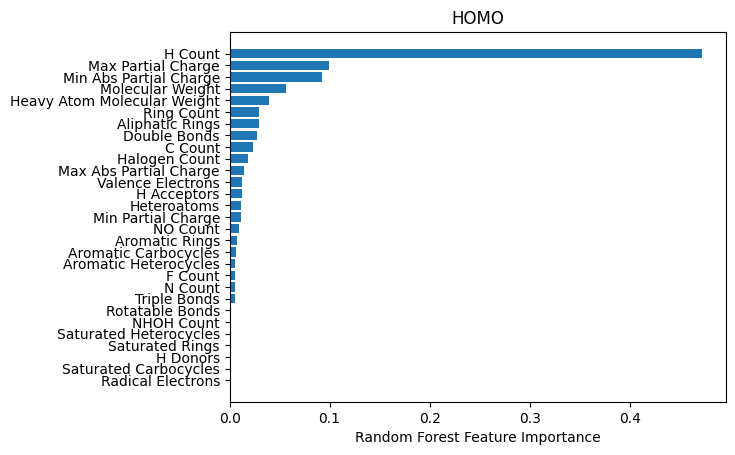

In [59]:
rfr = RandomForestRegressor(random_state=42, max_depth=20, min_samples_leaf=1, min_samples_split=2)
rfr.fit(X_train, y_train)

sorted_idx = rfr.feature_importances_.argsort()
plt.barh(list_numerical[sorted_idx], rfr.feature_importances_[sorted_idx])
plt.xlabel("Random Forest Feature Importance")
plt.title("HOMO")

r = permutation_importance(rfr, X_train, y_train,
                            n_repeats=30,
                            random_state=0)

for i in r.importances_mean.argsort()[::-1]:
     if r.importances_mean[i] - 2 * r.importances_std[i] > 0:
         print(f"{list_numerical[i]:<8}"
               f"{r.importances_mean[i]:.3f}"
               f" +/- {r.importances_std[i]:.3f}")

In [60]:
data = pd.read_csv('Dopant_Data.csv')

# get data
data.replace([np.inf, -np.inf], np.nan, inplace=True)
data = data.dropna()
y = data['HOMO']
X = data.loc[:, ['Molecular Weight', 'Heavy Atom Molecular Weight', 'Max Abs Partial Charge', 'Max Partial Charge', 
         'Min Abs Partial Charge', 'Min Partial Charge', 'Valence Electrons','NO Count',
         'H Acceptors', 'Ring Count', 'Aliphatic Rings', 'Aromatic Rings', 'Aromatic Carbocycles',
         'Aromatic Heterocycles', 'Heteroatoms', 'H Count',
         'C Count', 'N Count', 'F Count', 'Halogen Count', 'Double Bonds', 'Triple Bonds']]
list_numerical = X.columns


# split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=10)

param_grid = {
    "max_depth": [3,5,10,15,20,None],
    "min_samples_split": [2,5,7,10],
    "min_samples_leaf": [1,2,5]
}

cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
rf = RandomForestRegressor(random_state=42)
grid_cv = GridSearchCV(rf, param_grid, scoring=score, n_jobs=-1, cv=cv).fit(X_train, y_train)

print("Param for GS", grid_cv.best_params_)
print("CV score for GS", grid_cv.best_score_)
print("Train AUC ROC Score for GS: ", naive_roc_auc_score(y_train, grid_cv.predict(X_train)))
print("Test AUC ROC Score for GS: ",naive_roc_auc_score(y_test, grid_cv.predict(X_test)))
print("Train R2: ", r2_score(y_train, grid_cv.predict(X_train)))
print("Test R2: ", r2_score(y_test, grid_cv.predict(X_test)))
# rmse = mse**.5
print("Train MSE: ", mean_squared_error(y_train, grid_cv.predict(X_train)))
print("Test MSE: ", mean_squared_error(y_test, grid_cv.predict(X_test)))

Param for GS {'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 10}
CV score for GS 0.7805555555555553
Train AUC ROC Score for GS:  0.9032051282051282
Test AUC ROC Score for GS:  0.7
Train R2:  0.8472076305332545
Test R2:  0.35271811812953
Train MSE:  0.5503866944791332
Test MSE:  1.203602350581741


H Count 0.712 +/- 0.159
Min Abs Partial Charge0.091 +/- 0.026
Max Partial Charge0.054 +/- 0.017
Heavy Atom Molecular Weight0.031 +/- 0.013
Molecular Weight0.028 +/- 0.012
Double Bonds0.020 +/- 0.005
Aliphatic Rings0.015 +/- 0.004
Halogen Count0.007 +/- 0.003
Max Abs Partial Charge0.004 +/- 0.001
Valence Electrons0.004 +/- 0.001
Aromatic Carbocycles0.003 +/- 0.001
Aromatic Heterocycles0.003 +/- 0.001
H Acceptors0.002 +/- 0.001
Triple Bonds0.002 +/- 0.001
N Count 0.001 +/- 0.001


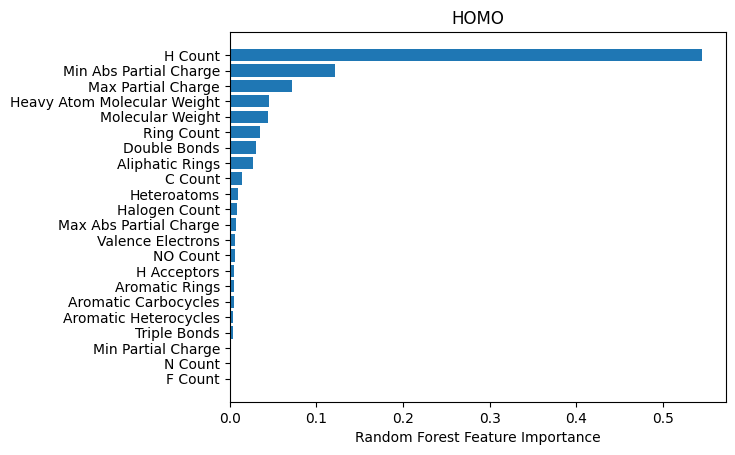

In [61]:
rfr = RandomForestRegressor(random_state=42, max_depth=20, min_samples_leaf=1, min_samples_split=10)
rfr.fit(X_train, y_train)

sorted_idx = rfr.feature_importances_.argsort()
plt.barh(list_numerical[sorted_idx], rfr.feature_importances_[sorted_idx])
plt.xlabel("Random Forest Feature Importance")
plt.title("HOMO")

r = permutation_importance(rfr, X_train, y_train,
                            n_repeats=30,
                            random_state=0)

for i in r.importances_mean.argsort()[::-1]:
     if r.importances_mean[i] - 2 * r.importances_std[i] > 0:
         print(f"{list_numerical[i]:<8}"
               f"{r.importances_mean[i]:.3f}"
               f" +/- {r.importances_std[i]:.3f}")

In [62]:
data = pd.read_csv('Dopant_Data.csv')

# get data
data.replace([np.inf, -np.inf], np.nan, inplace=True)
data = data.dropna()
y = data['HOMO']
X = data.loc[:, ['Molecular Weight', 'Heavy Atom Molecular Weight', 'Max Abs Partial Charge', 
         'Min Abs Partial Charge',  'Valence Electrons','NO Count',
         'H Acceptors', 'Ring Count', 'Aliphatic Rings', 'Aromatic Rings', 'Aromatic Carbocycles',
         'Aromatic Heterocycles', 'Heteroatoms', 'H Count',
         'C Count','Halogen Count', 'Double Bonds', 'Triple Bonds']]
list_numerical = X.columns


# split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=10)

param_grid = {
    "max_depth": [3,5,10,15,20,None],
    "min_samples_split": [2,5,7,10],
    "min_samples_leaf": [1,2,5]
}

cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
rf = RandomForestRegressor(random_state=42)
grid_cv = GridSearchCV(rf, param_grid, scoring=score, n_jobs=-1, cv=cv).fit(X_train, y_train)

print("Param for GS", grid_cv.best_params_)
print("CV score for GS", grid_cv.best_score_)
print("Train AUC ROC Score for GS: ", naive_roc_auc_score(y_train, grid_cv.predict(X_train)))
print("Test AUC ROC Score for GS: ",naive_roc_auc_score(y_test, grid_cv.predict(X_test)))
print("Train R2: ", r2_score(y_train, grid_cv.predict(X_train)))
print("Test R2: ", r2_score(y_test, grid_cv.predict(X_test)))
# rmse = mse**.5
print("Train MSE: ", mean_squared_error(y_train, grid_cv.predict(X_train)))
print("Test MSE: ", mean_squared_error(y_test, grid_cv.predict(X_test)))

Param for GS {'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 10}
CV score for GS 0.7638888888888888
Train AUC ROC Score for GS:  0.8903846153846153
Test AUC ROC Score for GS:  0.7
Train R2:  0.8343319573221921
Test R2:  0.3876605717291728
Train MSE:  0.5967672777671786
Test MSE:  1.138627846481471


H Count 0.741 +/- 0.166
Min Abs Partial Charge0.208 +/- 0.056
Heavy Atom Molecular Weight0.033 +/- 0.014
Molecular Weight0.022 +/- 0.010
Double Bonds0.021 +/- 0.006
Ring Count0.012 +/- 0.005
Aliphatic Rings0.011 +/- 0.003
Max Abs Partial Charge0.006 +/- 0.001
Halogen Count0.004 +/- 0.002
Triple Bonds0.003 +/- 0.001
Valence Electrons0.003 +/- 0.001
Aromatic Carbocycles0.002 +/- 0.001
H Acceptors0.001 +/- 0.001


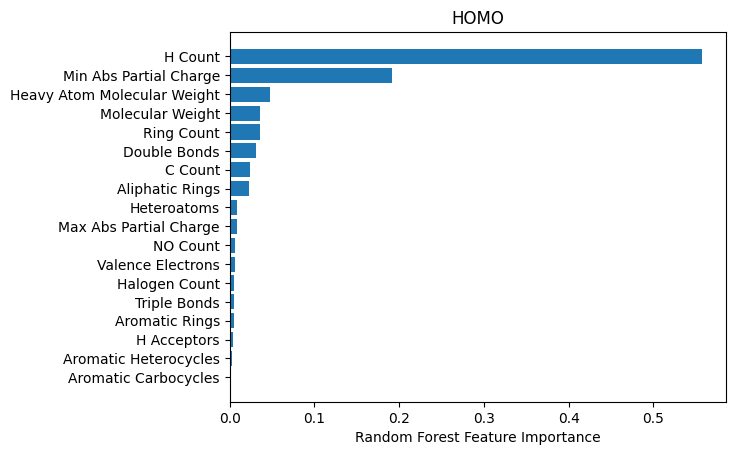

In [63]:
rfr = RandomForestRegressor(random_state=42, max_depth=3, min_samples_leaf=1, min_samples_split=10)
rfr.fit(X_train, y_train)

sorted_idx = rfr.feature_importances_.argsort()
plt.barh(list_numerical[sorted_idx], rfr.feature_importances_[sorted_idx])
plt.xlabel("Random Forest Feature Importance")
plt.title("HOMO")

r = permutation_importance(rfr, X_train, y_train,
                            n_repeats=30,
                            random_state=0)

for i in r.importances_mean.argsort()[::-1]:
     if r.importances_mean[i] - 2 * r.importances_std[i] > 0:
         print(f"{list_numerical[i]:<8}"
               f"{r.importances_mean[i]:.3f}"
               f" +/- {r.importances_std[i]:.3f}")

In [64]:
data = pd.read_csv('Dopant_Data.csv')

# get data
data.replace([np.inf, -np.inf], np.nan, inplace=True)
data = data.dropna()
y = data['HOMO']
X = data.loc[:, ['Molecular Weight', 'Heavy Atom Molecular Weight', 'Max Abs Partial Charge', 
         'Min Abs Partial Charge',  'Valence Electrons','NO Count',
        'Ring Count', 'Aliphatic Rings', 'Aromatic Rings', 'Heteroatoms', 'H Count',
         'C Count','Halogen Count', 'Double Bonds',]]
list_numerical = X.columns


# split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=10)

param_grid = {
    "max_depth": [3,5,10,15,20,None],
    "min_samples_split": [2,5,7,10],
    "min_samples_leaf": [1,2,5]
}

cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
rf = RandomForestRegressor(random_state=42)
grid_cv = GridSearchCV(rf, param_grid, scoring=score, n_jobs=-1, cv=cv).fit(X_train, y_train)

print("Param for GS", grid_cv.best_params_)
print("CV score for GS", grid_cv.best_score_)
print("Train AUC ROC Score for GS: ", naive_roc_auc_score(y_train, grid_cv.predict(X_train)))
print("Test AUC ROC Score for GS: ",naive_roc_auc_score(y_test, grid_cv.predict(X_test)))
print("Train R2: ", r2_score(y_train, grid_cv.predict(X_train)))
print("Test R2: ", r2_score(y_test, grid_cv.predict(X_test)))
# rmse = mse**.5
print("Train MSE: ", mean_squared_error(y_train, grid_cv.predict(X_train)))
print("Test MSE: ", mean_squared_error(y_test, grid_cv.predict(X_test)))

Param for GS {'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 2}
CV score for GS 0.7722222222222221
Train AUC ROC Score for GS:  0.9262820512820513
Test AUC ROC Score for GS:  0.7
Train R2:  0.935951320101402
Test R2:  0.3398853025750961
Train MSE:  0.23071532523627622
Test MSE:  1.2274646081213234


H Count 0.758 +/- 0.168
Min Abs Partial Charge0.216 +/- 0.055
Molecular Weight0.038 +/- 0.014
Heavy Atom Molecular Weight0.027 +/- 0.009
Double Bonds0.024 +/- 0.006
Halogen Count0.024 +/- 0.007
Aliphatic Rings0.022 +/- 0.005
Max Abs Partial Charge0.019 +/- 0.008
C Count 0.015 +/- 0.006
Ring Count0.012 +/- 0.005
Aromatic Rings0.009 +/- 0.003
NO Count0.009 +/- 0.003
Valence Electrons0.008 +/- 0.002
Heteroatoms0.006 +/- 0.002


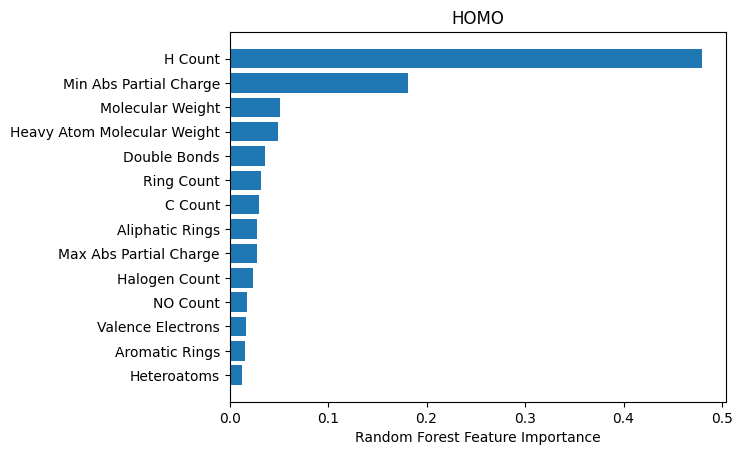

In [65]:
rfr = RandomForestRegressor(random_state=42, max_depth=5, min_samples_leaf=1, min_samples_split=2)
rfr.fit(X_train, y_train)

sorted_idx = rfr.feature_importances_.argsort()
plt.barh(list_numerical[sorted_idx], rfr.feature_importances_[sorted_idx])
plt.xlabel("Random Forest Feature Importance")
plt.title("HOMO")

r = permutation_importance(rfr, X_train, y_train,
                            n_repeats=30,
                            random_state=0)

for i in r.importances_mean.argsort()[::-1]:
     if r.importances_mean[i] - 2 * r.importances_std[i] > 0:
         print(f"{list_numerical[i]:<8}"
               f"{r.importances_mean[i]:.3f}"
               f" +/- {r.importances_std[i]:.3f}")

In [66]:
data = pd.read_csv('Dopant_Data.csv')

# get data
data.replace([np.inf, -np.inf], np.nan, inplace=True)
data = data.dropna()
y = data['HOMO']
X = data.loc[:, ['Molecular Weight', 'Max Abs Partial Charge', 
         'Min Abs Partial Charge',  'Valence Electrons','NO Count',
        'Ring Count', 'Aliphatic Rings', 'Aromatic Rings', 'H Count',
         'C Count','Halogen Count', 'Double Bonds',]]
list_numerical = X.columns


# split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=10)

param_grid = {
    "max_depth": [3,5,10,15,20,None],
    "min_samples_split": [2,5,7,10],
    "min_samples_leaf": [1,2,5]
}

cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
rf = RandomForestRegressor(random_state=42)
grid_cv = GridSearchCV(rf, param_grid, scoring=score, n_jobs=-1, cv=cv).fit(X_train, y_train)

print("Param for GS", grid_cv.best_params_)
print("CV score for GS", grid_cv.best_score_)
print("Train AUC ROC Score for GS: ", naive_roc_auc_score(y_train, grid_cv.predict(X_train)))
print("Test AUC ROC Score for GS: ",naive_roc_auc_score(y_test, grid_cv.predict(X_test)))
print("Train R2: ", r2_score(y_train, grid_cv.predict(X_train)))
print("Test R2: ", r2_score(y_test, grid_cv.predict(X_test)))
# rmse = mse**.5
print("Train MSE: ", mean_squared_error(y_train, grid_cv.predict(X_train)))
print("Test MSE: ", mean_squared_error(y_test, grid_cv.predict(X_test)))

Param for GS {'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 10}
CV score for GS 0.7694444444444443
Train AUC ROC Score for GS:  0.8775641025641026
Test AUC ROC Score for GS:  0.7
Train R2:  0.8301798097423165
Test R2:  0.3994651184301137
Train MSE:  0.6117240900049431
Test MSE:  1.1166776257897575


H Count 0.767 +/- 0.169
Min Abs Partial Charge0.211 +/- 0.057
Molecular Weight0.053 +/- 0.021
Double Bonds0.022 +/- 0.006
Aliphatic Rings0.016 +/- 0.004
Max Abs Partial Charge0.008 +/- 0.001
Aromatic Rings0.007 +/- 0.003
Halogen Count0.007 +/- 0.003
Valence Electrons0.007 +/- 0.003


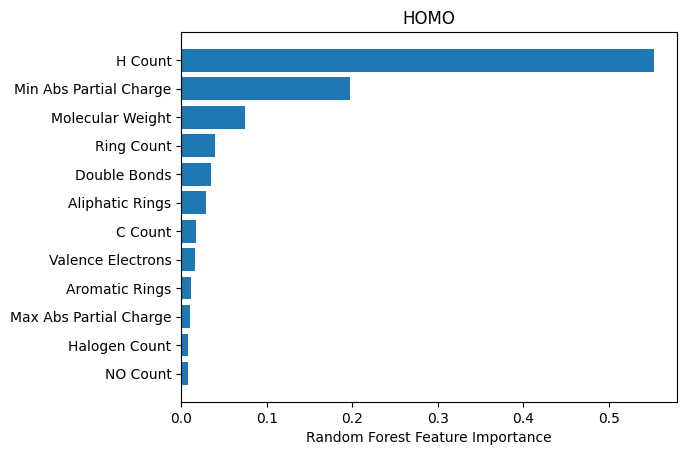

In [67]:
rfr = RandomForestRegressor(random_state=42, max_depth=5, min_samples_leaf=1, min_samples_split=10)
rfr.fit(X_train, y_train)

sorted_idx = rfr.feature_importances_.argsort()
plt.barh(list_numerical[sorted_idx], rfr.feature_importances_[sorted_idx])
plt.xlabel("Random Forest Feature Importance")
plt.title("HOMO")

r = permutation_importance(rfr, X_train, y_train,
                            n_repeats=30,
                            random_state=0)

for i in r.importances_mean.argsort()[::-1]:
     if r.importances_mean[i] - 2 * r.importances_std[i] > 0:
         print(f"{list_numerical[i]:<8}"
               f"{r.importances_mean[i]:.3f}"
               f" +/- {r.importances_std[i]:.3f}")

In [68]:
data = pd.read_csv('Dopant_Data.csv')

# get data
data.replace([np.inf, -np.inf], np.nan, inplace=True)
data = data.dropna()
y = data['HOMO']
X = data.loc[:, ['Molecular Weight', 'Max Abs Partial Charge', 
         'Min Abs Partial Charge',  'Valence Electrons',
        'Ring Count', 'Aliphatic Rings', 'Aromatic Rings', 'H Count',
         'C Count', 'Double Bonds',]]
list_numerical = X.columns


# split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=10)

param_grid = {
    "max_depth": [3,5,10,15,20,None],
    "min_samples_split": [2,5,7,10],
    "min_samples_leaf": [1,2,5]
}

cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
rf = RandomForestRegressor(random_state=42)
grid_cv = GridSearchCV(rf, param_grid, scoring=score, n_jobs=-1, cv=cv).fit(X_train, y_train)

print("Param for GS", grid_cv.best_params_)
print("CV score for GS", grid_cv.best_score_)
print("Train AUC ROC Score for GS: ", naive_roc_auc_score(y_train, grid_cv.predict(X_train)))
print("Test AUC ROC Score for GS: ",naive_roc_auc_score(y_test, grid_cv.predict(X_test)))
print("Train R2: ", r2_score(y_train, grid_cv.predict(X_train)))
print("Test R2: ", r2_score(y_test, grid_cv.predict(X_test)))
# rmse = mse**.5
print("Train MSE: ", mean_squared_error(y_train, grid_cv.predict(X_train)))
print("Test MSE: ", mean_squared_error(y_test, grid_cv.predict(X_test)))

Param for GS {'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 10}
CV score for GS 0.763888888888889
Train AUC ROC Score for GS:  0.8814102564102564
Test AUC ROC Score for GS:  0.7
Train R2:  0.8282038602351199
Test R2:  0.3685072009064573
Train MSE:  0.618841829729245
Test MSE:  1.1742429977617248


H Count 0.767 +/- 0.171
Min Abs Partial Charge0.212 +/- 0.057
Molecular Weight0.066 +/- 0.026
Double Bonds0.024 +/- 0.007
Aliphatic Rings0.013 +/- 0.004
Aromatic Rings0.005 +/- 0.003
Max Abs Partial Charge0.005 +/- 0.001


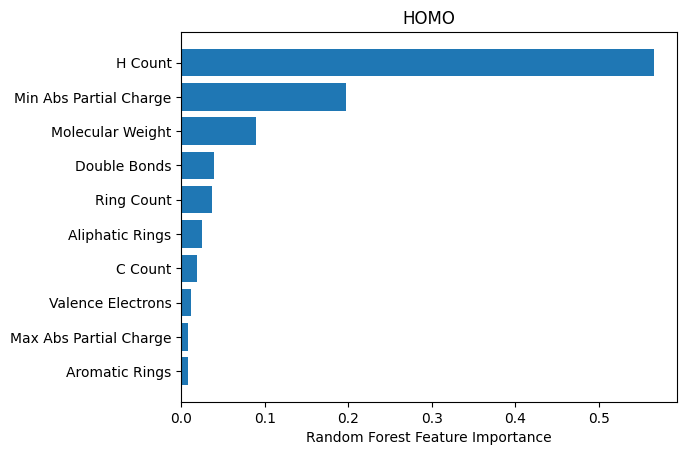

In [69]:
rfr = RandomForestRegressor(random_state=42, max_depth=3, min_samples_leaf=1, min_samples_split=10)
rfr.fit(X_train, y_train)

sorted_idx = rfr.feature_importances_.argsort()
plt.barh(list_numerical[sorted_idx], rfr.feature_importances_[sorted_idx])
plt.xlabel("Random Forest Feature Importance")
plt.title("HOMO")

r = permutation_importance(rfr, X_train, y_train,
                            n_repeats=30,
                            random_state=0)

for i in r.importances_mean.argsort()[::-1]:
     if r.importances_mean[i] - 2 * r.importances_std[i] > 0:
         print(f"{list_numerical[i]:<8}"
               f"{r.importances_mean[i]:.3f}"
               f" +/- {r.importances_std[i]:.3f}")

In [70]:
data = pd.read_csv('Dopant_Data.csv')

# get data
data.replace([np.inf, -np.inf], np.nan, inplace=True)
data = data.dropna()
y = data['HOMO']
X = data.loc[:, ['Molecular Weight',
         'Min Abs Partial Charge',
        'Ring Count', 'Aliphatic Rings', 'H Count',
         'C Count', 'Double Bonds',]]
list_numerical = X.columns


# split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=10)

param_grid = {
    "max_depth": [3,5,10,15,20,None],
    "min_samples_split": [2,5,7,10],
    "min_samples_leaf": [1,2,5]
}

cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
rf = RandomForestRegressor(random_state=42)
grid_cv = GridSearchCV(rf, param_grid, scoring=score, n_jobs=-1, cv=cv).fit(X_train, y_train)

print("Param for GS", grid_cv.best_params_)
print("CV score for GS", grid_cv.best_score_)
print("Train AUC ROC Score for GS: ", naive_roc_auc_score(y_train, grid_cv.predict(X_train)))
print("Test AUC ROC Score for GS: ",naive_roc_auc_score(y_test, grid_cv.predict(X_test)))
print("Train R2: ", r2_score(y_train, grid_cv.predict(X_train)))
print("Test R2: ", r2_score(y_test, grid_cv.predict(X_test)))
# rmse = mse**.5
print("Train MSE: ", mean_squared_error(y_train, grid_cv.predict(X_train)))
print("Test MSE: ", mean_squared_error(y_test, grid_cv.predict(X_test)))

Param for GS {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2}
CV score for GS 0.7833333333333332
Train AUC ROC Score for GS:  0.9301282051282052
Test AUC ROC Score for GS:  0.7
Train R2:  0.9396716935532474
Test R2:  0.30110091336516087
Train MSE:  0.21731384417059516
Test MSE:  1.2995830828174786


H Count 0.804 +/- 0.184
Min Abs Partial Charge0.263 +/- 0.063
Molecular Weight0.120 +/- 0.036
Double Bonds0.043 +/- 0.012
Aliphatic Rings0.030 +/- 0.006
Ring Count0.019 +/- 0.006
C Count 0.019 +/- 0.007


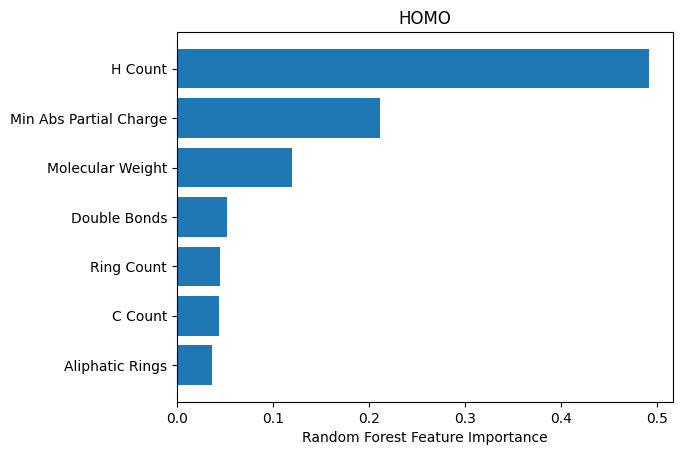

In [72]:
rfr = RandomForestRegressor(random_state=42, max_depth=10, min_samples_leaf=1, min_samples_split=2)
rfr.fit(X_train, y_train)

sorted_idx = rfr.feature_importances_.argsort()
plt.barh(list_numerical[sorted_idx], rfr.feature_importances_[sorted_idx])
plt.xlabel("Random Forest Feature Importance")
plt.title("HOMO")

r = permutation_importance(rfr, X_train, y_train,
                            n_repeats=30,
                            random_state=0)

for i in r.importances_mean.argsort()[::-1]:
     if r.importances_mean[i] - 2 * r.importances_std[i] > 0:
         print(f"{list_numerical[i]:<8}"
               f"{r.importances_mean[i]:.3f}"
               f" +/- {r.importances_std[i]:.3f}")

In [74]:
data = pd.read_csv('Dopant_Data.csv')

# get data
data.replace([np.inf, -np.inf], np.nan, inplace=True)
data = data.dropna()
y = data['HOMO']
X = data.loc[:, ['Molecular Weight',
         'Min Abs Partial Charge',
        'Ring Count', 'H Count', 'Double Bonds', 'Aliphatic Rings']]
list_numerical = X.columns


# split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=10)

param_grid = {
    "max_depth": [3,5,10,15,20,None],
    "min_samples_split": [2,5,7,10],
    "min_samples_leaf": [1,2,5]
}

cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
rf = RandomForestRegressor(random_state=42)
grid_cv = GridSearchCV(rf, param_grid, scoring=score, n_jobs=-1, cv=cv).fit(X_train, y_train)

print("Param for GS", grid_cv.best_params_)
print("CV score for GS", grid_cv.best_score_)
print("Train AUC ROC Score for GS: ", naive_roc_auc_score(y_train, grid_cv.predict(X_train)))
print("Test AUC ROC Score for GS: ",naive_roc_auc_score(y_test, grid_cv.predict(X_test)))
print("Train R2: ", r2_score(y_train, grid_cv.predict(X_train)))
print("Test R2: ", r2_score(y_test, grid_cv.predict(X_test)))
# rmse = mse**.5
print("Train MSE: ", mean_squared_error(y_train, grid_cv.predict(X_train)))
print("Test MSE: ", mean_squared_error(y_test, grid_cv.predict(X_test)))

Param for GS {'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 10}
CV score for GS 0.7833333333333332
Train AUC ROC Score for GS:  0.8884615384615384
Test AUC ROC Score for GS:  0.7
Train R2:  0.8276993702616042
Test R2:  0.3842215048563854
Train MSE:  0.6206590969781934
Test MSE:  1.1450226940553492


H Count 0.783 +/- 0.175
Min Abs Partial Charge0.216 +/- 0.059
Molecular Weight0.085 +/- 0.032
Double Bonds0.027 +/- 0.007
Ring Count0.017 +/- 0.007
Aliphatic Rings0.014 +/- 0.004


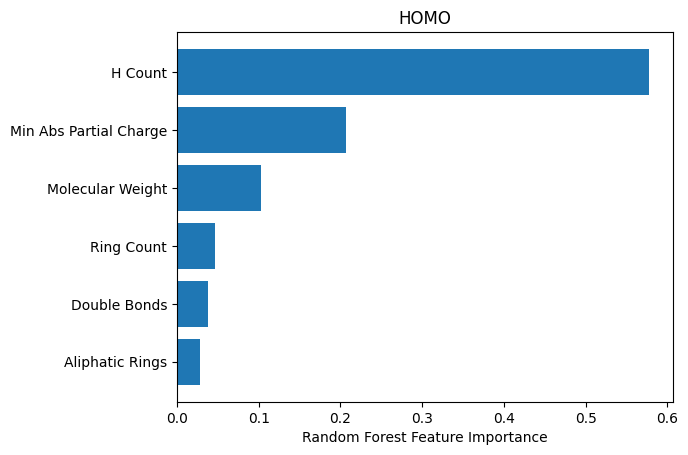

In [75]:
rfr = RandomForestRegressor(random_state=42, max_depth=3, min_samples_leaf=1, min_samples_split=10)
rfr.fit(X_train, y_train)

sorted_idx = rfr.feature_importances_.argsort()
plt.barh(list_numerical[sorted_idx], rfr.feature_importances_[sorted_idx])
plt.xlabel("Random Forest Feature Importance")
plt.title("HOMO")

r = permutation_importance(rfr, X_train, y_train,
                            n_repeats=30,
                            random_state=0)

for i in r.importances_mean.argsort()[::-1]:
     if r.importances_mean[i] - 2 * r.importances_std[i] > 0:
         print(f"{list_numerical[i]:<8}"
               f"{r.importances_mean[i]:.3f}"
               f" +/- {r.importances_std[i]:.3f}")